**Securing Data Transmission: Cryptology, Watermarking and Steganography**

**AGH University of Science and Technology**

**Faculty:** Computer Science, Electronics and Telecommunications

**Field of study:**	Electronics and Telecommunications

**Year of study:**	III

**Date:**			04.06.2021

**Students name:**
*   Jakub Pasoń (305259)
*   Seweryn Dumania (305254)
*   Hubert Hanusiak (305256)
*   Maciej Śliwiński (297162)


**Topic:** Elliptic Curve Diffie-Hellman (Implementation of curves 448 and 25519)

**Supervisor:** Prof. Dr Hab. Piotr Chołda




**Introduction + aim of the project**

Our goal is to implement an ECDH key exchange algorithm in order to get a shared key that can be used for message encryption. We also used two of the most popular curves - 448 & 25519 and compared their performance. 




Eliptic Curve Crypthography (ECC) is nowadays one of the most researched encryption schemes, which in comparison to RSA is more efficient, less energy consumpting and more immune to attacks. While RSA uses exponantiation, ECC is based on Eliptic Curves operations (scalar multipliaction, point addition). Moreover it is not proved that RSA can be cracked nowadays, we must be aware that in the future it may be prone to new attacks (especially in 5G), this is why ECC can take the place of RSA.  


#ECDH 448

In [ ]:
import os
import binascii

In [ ]:
def bytes_to_int_448(bytes):
    result = 0
    for b in bytes:
        result = int(result * 256) + int(b)
    return int(result)

def int_to_bytes_448(value, length):
    result = []
    for i in range(0, length):
        result.append(value >> (i * 8) & 0xff)
    return result

Conversion between bytes and integer representation

In [ ]:
def decodeLittleEndian_448(b):
    return sum([b[i] << 8 * i for i in range(56)])      # 56 bytes string (input & output)


Array of bytes in little-endian order due to convention for 56 byte string for Curve 448

In [ ]:
def decodeScalar448(k):
    k_list = [(b) for b in k]
    k_list[0] &= 252    # 1111 1000
    k_list[55] |= 128   # 1000 0000
    return decodeLittleEndian_448(k_list)

Here we want to decode the 56 random bytes as an integer scalar.

For Curve 448 we set the two least significant bit of the last byte to 0 and the most significant bit of the last byte to 1 

In [ ]:
def cswap_448(swap, x_2, x_3):
    swap *= -1
    dummy = swap & (x_2 ^ x_3)
    x_2 ^= dummy
    x_3 ^= dummy
    return x_2, x_3

 Constant time conditional swap function - returning either **(x_2,x_3)** when scalar bit **swap** is cleared else **(x_3,x_2)**
 
This function is a countermeasure for potential cache-based attacks which could reveal the scalar digits

In [ ]:
def X448(k, u):
    x_1 = u
    x_2 = 1
    z_2 = 0
    x_3 = u
    z_3 = 1
    swap = 0

    for t in reversed(range(448)):
        k_t = (k >> t) & 1
        swap ^= k_t
        x_2, x_3 = cswap_448(swap, x_2, x_3)
        z_2, z_3 = cswap_448(swap, z_2, z_3)
        swap = k_t

        A = x_2 + z_2
        AA = A * A

        B = x_2 - z_2
        BB = B * B

        E = AA - BB

        C = x_3 + z_3
        D = x_3 - z_3

        DA = D * A
        CB = C * B

        x_3 = ((DA + CB) % P_448) ** 2
        x_3 %= P_448

        z_3 = x_1 * (((DA - CB) % P_448) ** 2) % P_448
        z_3 %= P_448

        x_2 = AA * BB
        x_2 %= P_448

        z_2 = E * ((AA + (A24_448 * E) % P_448) % P_448)
        z_2 %= P_448

    x_2, x_3 = cswap_448(swap, x_2, x_3)
    z_2, z_3 = cswap_448(swap, z_2, z_3)

    return (x_2 * pow(z_2, P_448 - 2, P_448)) % P_448

Function for Curve 448 implementation which takes two parameters:


*   k - scalar
*   u - u coordinate

In this function we ensure that we operate at the defined Galois Field for specific prime number 2^448 - 2^224 - 1

In [ ]:
def decodeUCoordinate_448(s):
    if len(s) != 56:
        raise ValueError('Invalid Curve448 scalar (len=%d)' % len(s))
    return sum(ord(s[i]) << (8 * i) for i in range(56))

def encodeUCoordinate_448(n):
    return ''.join([chr((n >> (8 * i)) & 255) for i in range(56)])

Encoding and decoding to and from little-endian for u-coordinate



In [ ]:
# Return nP
def multscalar_448(n, p):
    n = decodeScalar448(n) % P_448
    p = decodeUCoordinate_448(p)
    return encodeUCoordinate_448(X448(n, p))

Scalar multiplication for any point on the Eliptic curve

In [ ]:
def base_point_mult_448(n):
    n = decodeScalar448(n) % P_448                  # u-coordinate of the base point encoded as a byte with value 5,
    return encodeUCoordinate_448(X448(n, 5))        # followed by 55 zero bytes

Base point multiplication ( for Curve 448 = 5), from this point all the scalar operations begin

## ECDH Curve 448 simulation

In [ ]:
P_448 = 2 ** 448 - 2 ** 224 - 1
A24_448 = 156326         #y^2 + x^2 = 1 - 156326*x^2*y^2

a = os.urandom(56)       # generating random 56-bytes strings (private a)
b = os.urandom(56)       # generating random 56-bytes strings (private b)


print(f"\nAlice private (a): \t{bytes_to_int_448(a)}")
print(f"Bob private (b):\t{bytes_to_int_448(b)}")


# Traditional ECDH:
a_pub = base_point_mult_448(a)      # a * G
b_pub = base_point_mult_448(b)      # b * G


print("\nAlice public (aG):\t", binascii.hexlify(a_pub.encode()))       # representing aG in hex (encode -> to ASCII)
print("Bob public (bG):\t", binascii.hexlify(b_pub.encode()))           # representing bG in hex (encode -> to ASCII)


k_a = multscalar_448(a, b_pub)    # a * (bG)
k_b = multscalar_448(b, a_pub)    # b * (aG)


print("\nAlice shared (a)bG:\t", binascii.hexlify(k_a.encode()))
print("Bob shared (b)aG:\t", binascii.hexlify(k_b.encode()))

print('\nAre equal: ', binascii.hexlify(k_a.encode()) == binascii.hexlify(k_b.encode()))


Alice private (a): 	408928707491328080926612213263456262343599757188351721513172161431199878444635285156232735085201293027151387024593264954858784461409605
Bob private (b):	426590600660812580902795769151115902876923029556501694425257824561947658324712152695011230874176940933770691705931146514446568418834852

Alice public (aG):	 b'2b2e43c298c28ac3a3c28e371d7721691dc2812dc3ab35430206c2a74e5437c2a1c3936f08c3af69c282c388c2a9c3a756c2b0c2abc3813348c3b236c280c398c2be6fc3bb650dc2903fc2abc2b31ec2bec3b9'
Bob public (bG):	 b'c2b2c3931ec2b3c29369c386c38fc2a6c2a1c28bc3a8c294c3b35876c2b84523c2a01932c38e59c3aa1ac29ec3a4c280c393c2b2c2b43527c2ad03c38bc3b46f6bc2ba0421c3a25d095ec394c3a965c389c395c29754c2890c'

Alice shared (a)bG:	 b'c295c2b074c383c3b1c3b0c3adc2bc32c3a9494965c285732dc395c2bcc28816c28175c391c2b9c2bac284c3b34117753bc2a267c28851185923c29916c3a142106e55c2994c1ec3b63f7579c2bf1f39c389'
Bob shared (b)aG:	 b'c295c2b074c383c3b1c3b0c3adc2bc32c3a9494965c285732dc395c2bcc28816c28175c391c2b9c2bac284c3

## Verification of the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

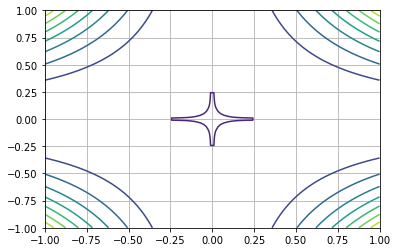

In [ ]:
y, x = np.ogrid[-1:1:100j, -1:1:100j]       # y^2 + x^2 = 1 - 156326*x^2*y^2
plt.contour(x.ravel(), y.ravel(), pow(y, 2) + pow(x, 2) - 1 + A24_448 * pow(x, 2) * pow(y, 2))
plt.grid()
plt.show()

## Performance test

In [ ]:
import time
import pandas as pd
import statistics

In [ ]:
n_448 = 200
samples_448 = []
for i in range(n_448):
    start = time.time()
    a = os.urandom(56)  # generating random 56-bytes strings (private a)
    b = os.urandom(56)  # generating random 56-bytes strings (private b)
    a_pub_perform = base_point_mult_448(a)  # a * G
    b_pub_perform = base_point_mult_448(b)  # b * G

    k_a = multscalar_448(a, b_pub)  # a * (bG)
    k_b = multscalar_448(b, a_pub)  # b * (aG)
    end = time.time()
    samples_448.append(end-start)

df_448 = pd.Series(samples_448)
mean448 = statistics.mean(samples_448)*1000
std448 = df_448.std()*1000
print('Average: ', mean448, 'ms')
print('Variance: ', std448, 'ms')

Average:  31.16312026977539 ms
Variance:  4.180624678874342 ms


#ECDH25519

In [ ]:
def bytes_to_int_25519(bytes):
    result = 0
    for b in bytes:
        result = result * 256 + int(b)
    return result

def int_to_bytes_25519(value, length):
    result = []
    for i in range(0, length):
        result.append(value >> (i * 8) & 0xff)
    return result

Conversion between bytes and integer representation

In [ ]:
def decodeLittleEndian_25519(b):
    return sum([b[i] << 8 * i for i in range(32)])

Array of bytes in little-endian order due to convention for 32 byte string for Curve 25519

In [ ]:
def decodeScalar25519(k):
    k_list = [b for b in k]
    k_list[0] &= 248    #248 = 1111 1000    #clears 3 LS bits
    k_list[31] &= 127   #127 = 0111 1111    #clears MS bit
    k_list[31] |= 64    #64  = 0100 0000    #sets 2nd to last MS bit to 1

    return decodeLittleEndian_25519(k_list)

Here we want to decode the 32 random bytes as an integer scalar.

For Curve 25519 we set the three least significant bits of the first byte, the most significant bit of the last byte to 0 and the second most significant bit of the last byte to 1

In [ ]:
def cswap_25519(swap, x_2, x_3):
    swap *= -1
    dummy = swap & (x_2 ^ x_3)
    x_2 ^= dummy
    x_3 ^= dummy
    return x_2, x_3

Constant time conditional swap function - returning either (x_2,x_3) when scalar bit swap is cleared else (x_3,x_2)

This function is a countermeasure for potential cache-based attacks which could reveal the scalar digits

In [ ]:
def X25519(k, u):
    x_1 = u
    x_2 = 1
    z_2 = 0
    x_3 = u
    z_3 = 1
    swap = 0

    for t in reversed(range(255)):
        k_t = (k >> t) & 1
        swap ^= k_t
        x_2, x_3 = cswap_25519(swap, x_2, x_3)
        z_2, z_3 = cswap_25519(swap, z_2, z_3)
        swap = k_t

        A = x_2 + z_2

        AA = A * A

        B = x_2 - z_2

        BB = B * B

        E = AA - BB

        C = x_3 + z_3

        D = x_3 - z_3
        DA = D * A
        CB = C * B

        x_3 = ((DA + CB) % P_25519) ** 2
        x_3 %= P_25519

        z_3 = x_1 * (((DA - CB) % P_25519) ** 2) % P_25519
        z_3 %= P_25519

        x_2 = AA * BB
        x_2 %= P_25519

        z_2 = E * ((AA + (A24_25519 * E) % P_25519) % P_25519)
        z_2 %= P_25519

    x_2, x_3 = cswap_25519(swap, x_2, x_3)
    z_2, z_3 = cswap_25519(swap, z_2, z_3)

    return (x_2 * pow(z_2, P_25519 - 2, P_25519)) % P_25519


Function for Curve 25519 implementation which takes two parameters:


*   k - scalar
*   u - u coordinate

In this function we ensure that we operate at the defined Galois Field for specific prime number 2^255 - 19

In [ ]:
def decodeUCoordinate_25519(s):
    if len(s) != 32:
        raise ValueError('Invalid Curve25519 scalar (len=%d)' % len(s))
    t = sum((ord(s[i])) << (8 * i) for i in range(31))
    t += (((ord(s[31])) & 0x7f) << 248)
    return t
    # This is done to preserve compatibility with point formats that
    # reserve the sign bit for use in other protocols
    # galois field is set of integers modulo P

def encodeUCoordinate_25519(n):
    return ''.join([chr((n >> (8 * i)) & 255) for i in range(32)])

Encoding and decoding to and from little-endian for u-coordinate

In [ ]:
# Return nP
def multscalar_25519(n, p):
    n = decodeScalar25519(n) % P_25519
    p = decodeUCoordinate_25519(p)
    return encodeUCoordinate_25519(X25519(n, p))

Scalar multiplication for any point on the Eliptic curve

In [ ]:
# Start at x=9. Find point n times x-point
def base_point_mult_25519(n):
    n = decodeScalar25519(n) % P_25519
    return encodeUCoordinate_25519(X25519(n, 9))

Base point multiplication ( for Curve 25519 = 9), from this point all the scalar operations begin

## ECDH Curve 25519 simulation

In [ ]:
P_25519 = 2 ** 255 - 19
A24_25519 = 486662       #y^2 + x^2 = 1 - 156326*x^2*y^2

a = os.urandom(32)       # generating random 32-bytes strings (private a)
b = os.urandom(32)       # generating random 32-bytes strings (private b)


print(f"\nAlice private (a): \t{bytes_to_int_25519(a)}")
print(f"Bob private (b):\t{bytes_to_int_25519(b)}")


# Traditional ECDH: 
a_pub = base_point_mult_25519(a)    # a * G
b_pub = base_point_mult_25519(b)    # b * G


print("\nAlice public (aG):\t", binascii.hexlify(a_pub.encode()))       # representing aG in hex (encode -> to ASCII)
print("Bob public (bG):\t", binascii.hexlify(b_pub.encode()))           # representing bG in hex (encode -> to ASCII)


k_a = multscalar_25519(a, b_pub)  # a * (bG)
k_b = multscalar_25519(b, a_pub)  # b * (aG)


print("\nAlice shared (a)bG:\t", binascii.hexlify(k_a.encode()))
print("Bob shared (b)aG:\t", binascii.hexlify(k_b.encode()))

print("\nAre equal: ", binascii.hexlify(k_a.encode()) == binascii.hexlify(k_b.encode()))


Alice private (a): 	107179069739012156919246421273997212251513418366390462616861731035269237815411
Bob private (b):	21124535343497202236924185811870228742411045348734263195118785842939661188367

Alice public (aG):	 b'58777b10c3bec287c3bfc3b4c3a90335577ac38dc38251c2b671c3b176c3b55040c2b1c387c3bd33c2b45fc2abc28263'
Bob public (bG):	 b'c2a0c2a478c2bc0552117911c380c3adc28bc3a6c29e4559c2a10c39c38412167bc2afc2b614c29bc3b92007c2be12'

Alice shared (a)bG:	 b'437103c3bdc3aec2b264c2afc3af0356c3ae2475c38dc293c38a0ac290c381c3ba1e1047c386c295c385c38e05c3b2c38a2c'
Bob shared (b)aG:	 b'437103c3bdc3aec2b264c2afc3af0356c3ae2475c38dc293c38a0ac290c381c3ba1e1047c386c295c385c38e05c3b2c38a2c'

Are equal:  True


## Verification of the results

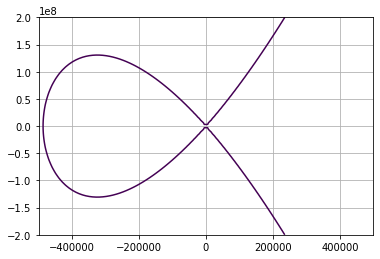

In [ ]:
y, x = np.ogrid[ -200000000:200000000:100j,-500000:500000:100j]
plt.contour(x.ravel(), y.ravel(), pow(y, 2) - pow(x, 3) - pow(x,2) * A24_25519 - x, [0])

plt.grid()
plt.show()

## Performance test

In [ ]:
n = 200
samples_25519 = []
for i in range(n):
    start = time.time()
    a = os.urandom(32)  # generating random 32-bytes strings (private a)
    b = os.urandom(32)  # generating random 32-bytes strings (private b)
    a_pub_perform = base_point_mult_25519(a)  # a * G
    b_pub_perform = base_point_mult_25519(b)  # b * G

    k_a = multscalar_25519(a, b_pub)  # a * (bG)
    k_b = multscalar_25519(b, a_pub)  # b * (aG)
    end = time.time()
    samples_25519.append(end-start)

df_25519 = pd.Series(samples_25519)

mean25519 = statistics.mean(samples_25519)*1000
std25519 = df_25519.std()*1000
print('Average: ', mean25519, 'ms')
print('Variance: ', std25519, 'ms')

Average:  10.915292501449585 ms
Variance:  1.1880270995070907 ms


#Summary

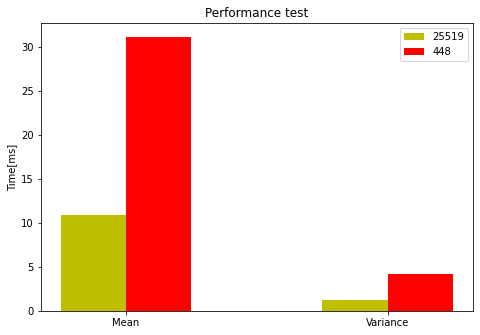

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(2)
curves = ['25519', '448']
data = [[mean25519, std25519], [mean448, std448]]
ax.bar(X + 0.00, data[0], color = 'y', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
ax.legend(labels=['25519', '448'])
ax.set_ylabel('Time[ms]')
ax.set_title('Performance test')
plt.xticks(X + 0.25 / 2, ('Mean', 'Variance'))
plt.show()